In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
imgs_path = "/content/drive/MyDrive/Data/images10000/"
imgs_model_width, imgs_model_height = 224, 224

In [7]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]
print("Total number of images:", len(files))

Total number of images: 10000


# EDA

In [8]:
styles = pd.read_csv("/content/drive/MyDrive/Data/styles.csv", error_bad_lines=False)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

# Men's goods *vs* women's goods

In [9]:
fig = px.pie(styles, styles['gender'], color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title="Goods distribution", width=800, height=800, font=dict(family="Segoe UI semilight", size=16))
fig.show()

In [10]:
catcounts=pd.value_counts(styles['masterCategory'])

# Most popular categories

In [11]:
fig = go.Figure([go.Bar(x=catcounts.index, y=catcounts.values, text=catcounts.values, marker_color='darkkhaki')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Top categories", width=1200, height=700, xaxis_title="Category",
                  yaxis_title="Orders quantity", font=dict(family="Segoe UI semilight", size=16))
fig.show()

Clothes are very popular.

# High sales season

In [12]:
seasons=pd.value_counts(styles['season'])

In [13]:
fig = go.Figure(data=[go.Scatter(x=seasons.index, y=seasons.values, mode='markers', 
    marker=dict(color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
                opacity=[0.6, 0.7, 0.8, 1], size=[123, 65, 49, 17]))])
fig.update_layout(title= "Orders quantity versus season", xaxis_title="Season", yaxis_title= "Orders quantity",
                  font=dict(family="Segoe UI semilight", size=16))
fig.show()

3/4 of the products are purchased during summer and fall.

# Most popular product types

In [14]:
articles = pd.value_counts(styles['articleType'])
fig = go.Figure([go.Bar(x=articles.index[:15], y=articles.values[:15], text=articles.values[:15], marker_color='darkmagenta')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Top 15 types", yaxis_title="Orders quantity",
                  width=950, height=750, font=dict(family="Segoe UI semilight", size=16))
fig.show()

T-shirts and shirts are top sellers. Perhaps, these are the most suitable summer and fall clothing in the region.

# Feature extraction of a single image

In order to reduce the execution time of the algorithm and prevent the kernel from stopping, we will reduce the data to 4000 images.

In [16]:
files=files[0:4001]

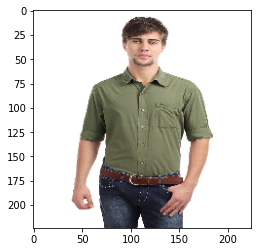

Sample image


In [52]:
original = load_img(files[843], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("Sample image")

NN inputs are 3-channel 224x224 images

In [53]:
# load weighted ImageNet
vgg_model = vgg16.VGG16(weights='imagenet');
# the network predicts classes, so we remove the last layer to get features
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output);
# let's look at the entire architecture
feat_extractor.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

With `preprocess_input` function, images are converted from RGB to BGR, then each color channel is centered against the ImageNet dataset without scaling.

In [54]:
numpy_image = img_to_array(original)
# convert the image to an array
# add one dimension
# the input data should be like that (batchsize, height, width, channels)
image_batch = np.expand_dims(numpy_image, axis=0)
print('Input data dimensions', image_batch.shape)
# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

Input data dimensions (1, 224, 224, 3)


In [55]:
img_features = feat_extractor.predict(processed_image)
print("Features of one image have been extracted")
print("Number of features:", img_features.size)

Extracted features of one image
Number of features: 4096


# Now we implement same procedures for the whole dataset

In [56]:
importedImages = []
for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)    
images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())

In [57]:
imgs_features = feat_extractor.predict(processed_imgs)
print("Features extracted")
imgs_features.shape

Features extracted


(1001, 4096)

In [59]:
print("Extracted", imgs_features.shape[1], "features for each of", imgs_features.shape[0], "images.")

Extracted 4096 features for each of 1001 images.


The selection of relevant products is based upon cosine similarity - the normalized scalar product of X and Y.

In [66]:
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df[:2]

,/content/drive/MyDrive/Data/images10000/58059.jpg,/content/drive/MyDrive/Data/images10000/58058.jpg,/content/drive/MyDrive/Data/images10000/58060.jpg,/content/drive/MyDrive/Data/images10000/58051.jpg,/content/drive/MyDrive/Data/images10000/58037.jpg,/content/drive/MyDrive/Data/images10000/58023.jpg,/content/drive/MyDrive/Data/images10000/58027.jpg,/content/drive/MyDrive/Data/images10000/58073.jpg,/content/drive/MyDrive/Data/images10000/58014.jpg,/content/drive/MyDrive/Data/images10000/58044.jpg,/content/drive/MyDrive/Data/images10000/58010.jpg,/content/drive/MyDrive/Data/images10000/58097.jpg,/content/drive/MyDrive/Data/images10000/58096.jpg,/content/drive/MyDrive/Data/images10000/58028.jpg,/content/drive/MyDrive/Data/images10000/58057.jpg,/content/drive/MyDrive/Data/images10000/58030.jpg,/content/drive/MyDrive/Data/images10000/58045.jpg,/content/drive/MyDrive/Data/images10000/58086.jpg,/content/drive/MyDrive/Data/images10000/58061.jpg,/content/drive/MyDrive/Data/images10000/58053.jpg,/content/drive/MyDrive/Data/images10000/58035.jpg,/content/drive/MyDrive/Data/images10000/58085.jpg,/content/drive/MyDrive/Data/images10000/58032.jpg,/content/drive/MyDrive/Data/images10000/58052.jpg,/content/drive/MyDrive/Data/images10000/58046.jpg,/content/drive/MyDrive/Data/images10000/58015.jpg,/content/drive/MyDrive/Data/images10000/58071.jpg,/content/drive/MyDrive/Data/images10000/58098.jpg,/content/drive/MyDrive/Data/images10000/58078.jpg,/content/drive/MyDrive/Data/images10000/58016.jpg,/content/drive/MyDrive/Data/images10000/58074.jpg,/content/drive/MyDrive/Data/images10000/58050.jpg,/content/drive/MyDrive/Data/images10000/58011.jpg,/content/drive/MyDrive/Data/images10000/58041.jpg,/content/drive/MyDrive/Data/images10000/58112.jpg,/content/drive/MyDrive/Data/images10000/58118.jpg,/content/drive/MyDrive/Data/images10000/58121.jpg,/content/drive/MyDrive/Data/images10000/58152.jpg,/content/drive/MyDrive/Data/images10000/58137.jpg,/content/drive/MyDrive/Data/images10000/58140.jpg,...,/content/drive/MyDrive/Data/images10000/8699.jpg,/content/drive/MyDrive/Data/images10000/8688.jpg,/content/drive/MyDrive/Data/images10000/8746.jpg,/content/drive/MyDrive/Data/images10000/8768.jpg,/content/drive/MyDrive/Data/images10000/8931.jpg,/content/drive/MyDrive/Data/images10000/8930.jpg,/content/drive/MyDrive/Data/images10000/8920.jpg,/content/drive/MyDrive/Data/images10000/8925.jpg,/content/drive/MyDrive/Data/images10000/8928.jpg,/content/drive/MyDrive/Data/images10000/8934.jpg,/content/drive/MyDrive/Data/images10000/8929.jpg,/content/drive/MyDrive/Data/images10000/8961.jpg,/content/drive/MyDrive/Data/images10000/9028.jpg,/content/drive/MyDrive/Data/images10000/9039.jpg,/content/drive/MyDrive/Data/images10000/9092.jpg,/content/drive/MyDrive/Data/images10000/9105.jpg,/content/drive/MyDrive/Data/images10000/9122.jpg,/content/drive/MyDrive/Data/images10000/9129.jpg,/content/drive/MyDrive/Data/images10000/9138.jpg,/content/drive/MyDrive/Data/images10000/9356.jpg,/content/drive/MyDrive/Data/images10000/9364.jpg,/content/drive/MyDrive/Data/images10000/9371.jpg,/content/drive/MyDrive/Data/images10000/9392.jpg,/content/drive/MyDrive/Data/images10000/9389.jpg,/content/drive/MyDrive/Data/images10000/9410.jpg,/content/drive/MyDrive/Data/images10000/9412.jpg,/content/drive/MyDrive/Data/images10000/9411.jpg,/content/drive/MyDrive/Data/images10000/9430.jpg,/content/drive/MyDrive/Data/images10000/9408.jpg,/content/drive/MyDrive/Data/images10000/9440.jpg,/content/drive/MyDrive/Data/images10000/9409.jpg,/content/drive/MyDrive/Data/images10000/9413.jpg,/content/drive/MyDrive/Data/images10000/9443.jpg,/content/drive/MyDrive/Data/images10000/9692.jpg,/content/drive/MyDrive/Data/images10000/9705.jpg,/content/drive/MyDrive/Data/images10000/9707.jpg,/content/drive/MyDrive/Data/images10000/9794.jpg,/content/drive/MyDrive/Data/images10000/9817.jpg,/content/drive/MyDrive/Data/images10000/9989.jpg,/content/drive/MyDrive/Data/images10000/55643.jpg
/content/drive/MyDrive/Data/images

In [67]:
# selection function of 4 relevant products based on the prior
nb_closest_images = 4
def retrieve_relevant_products(given_img):
    print("     Prior item")
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("    _____________________________")
    print("    Relevant items")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = 100*cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("     Similarity: ", round(closest_imgs_scores[i],2), "%")

     Prior item


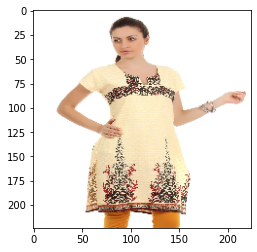

    _____________________________
    Relevant items


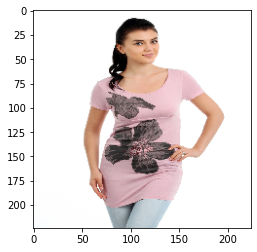

     Similarity:  76.98 %


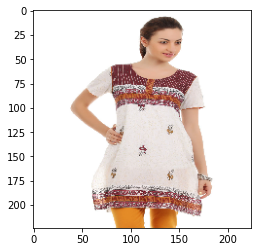

     Similarity:  74.82 %


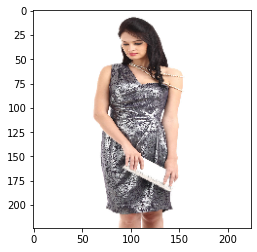

     Similarity:  73.99 %


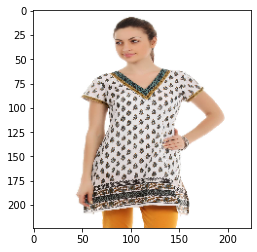

     Similarity:  73.55 %


In [68]:
retrieve_relevant_products(files[651])

     Prior item


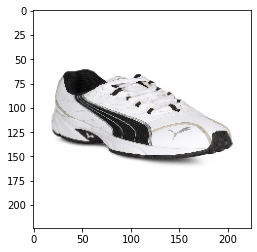

    _____________________________
    Relevant items


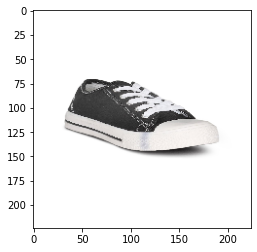

     Similarity:  80.64 %


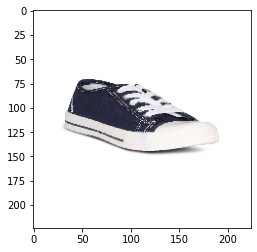

     Similarity:  76.97 %


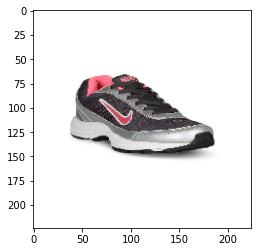

     Similarity:  74.0 %


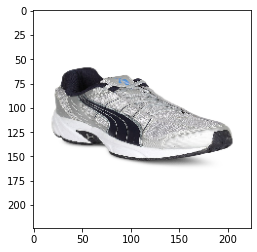

     Similarity:  72.89 %


In [69]:
retrieve_relevant_products(files[695])

On the one hand, clothing recommendations on models are more accurate: it is more difficult to determine gender on garments without a model.

Nevertheless, NN tends to consider garments on models to be similar if the models are similar.